# Assignment 13: Decision Tree

## Import Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

## 1. Load Dataset

In [2]:
df = pd.read_excel(r"C:\Users\test\datascience-22maybatch\Assignment\heart_disease.xlsx",sheet_name=1)


In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,thal,num
0,63,Male,typical angina,145,233,True,lv hypertrophy,150,False,2.3,downsloping,fixed defect,0
1,41,Male,atypical angina,135,203,False,normal,132,False,0.0,flat,fixed defect,0
2,57,Male,asymptomatic,140,192,False,normal,148,False,0.4,flat,fixed defect,0
3,52,Male,typical angina,118,186,False,lv hypertrophy,190,False,0.0,flat,fixed defect,0
4,57,Male,asymptomatic,110,201,False,normal,126,True,1.5,flat,fixed defect,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       908 non-null    int64  
 1   sex       908 non-null    object 
 2   cp        908 non-null    object 
 3   trestbps  908 non-null    int64  
 4   chol      908 non-null    int64  
 5   fbs       908 non-null    bool   
 6   restecg   908 non-null    object 
 7   thalch    908 non-null    int64  
 8   exang     908 non-null    object 
 9   oldpeak   846 non-null    float64
 10  slope     908 non-null    object 
 11  thal      908 non-null    object 
 12  num       908 non-null    int64  
dtypes: bool(1), float64(1), int64(5), object(6)
memory usage: 86.1+ KB


In [5]:
df.describe()

,age,trestbps,chol,thalch,oldpeak,num
count,908.000000,908.000000,908.000000,908.000000,846.000000,908.000000
mean,53.791850,133.430617,201.484581,135.957048,0.891253,1.008811
std,9.158031,20.401608,112.097949,26.804929,1.093875,1.144436
min,29.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.750000,120.000000,176.750000,118.000000,0.000000,0.000000
50%,54.000000,130.000000,224.000000,138.000000,0.500000,1.000000
75%,60.000000,144.000000,270.000000,156.000000,1.500000,2.000000
max,77.000000,200.000000,603.000000,202.000000,6.200000,4.000000


In [6]:
print(df.shape)

(908, 13)


In [7]:
df.isnull().sum()

age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalch       0
exang        0
oldpeak     62
slope        0
thal         0
num          0
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(1)

## 2. Exploratory Data Analysis (EDA):

In [9]:
#Hndling Missing Values
df['oldpeak'] = df['oldpeak'].fillna(df['oldpeak'].median())

In [10]:
#Convert Binary Categorical Colmns to numeric
df['sex'] = df['sex'].map({'Male':1,'Female':0})
df['fbs'] = df['fbs'].map({True:1,False:0})
df['exang'] = df['exang'].map({'Yes':1,'No':0})

In [11]:
#One Hot Encoding
cat_cols = ['cp', 'restecg', 'slope', 'thal']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [12]:
#Convert Traget variable to Binary
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df.drop(columns=['num'], inplace=True)

In [13]:
# Check final dataset
print(df.head())
print(df.columns)
print(df.isnull().sum())

   age  sex  trestbps  chol  fbs  thalch  exang  oldpeak  cp_atypical angina  \
0   63    1       145   233    1     150    NaN      2.3               False   
1   41    1       135   203    0     132    NaN      0.0                True   
2   57    1       140   192    0     148    NaN      0.4               False   
3   52    1       118   186    0     190    NaN      0.0               False   
4   57    1       110   201    0     126    NaN      1.5               False   

   cp_non-anginal  cp_typical angina  restecg_normal  \
0           False               True           False   
1           False              False            True   
2           False              False            True   
3           False               True           False   
4           False              False            True   

   restecg_st-t abnormality  slope_flat  slope_upsloping  thal_normal  \
0                     False       False            False        False   
1                     False        T

## Visualization

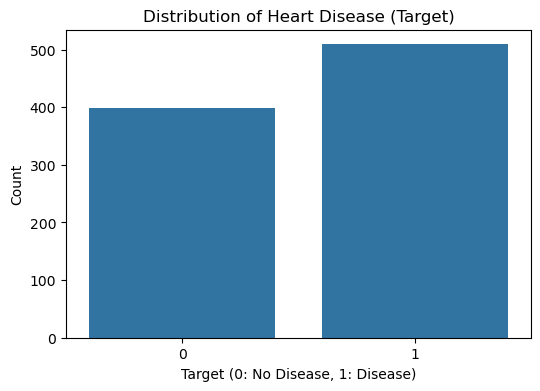

In [14]:
# Visualize the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Distribution of Heart Disease (Target)')
plt.xlabel('Target (0: No Disease, 1: Disease)')
plt.ylabel('Count')
plt.show()

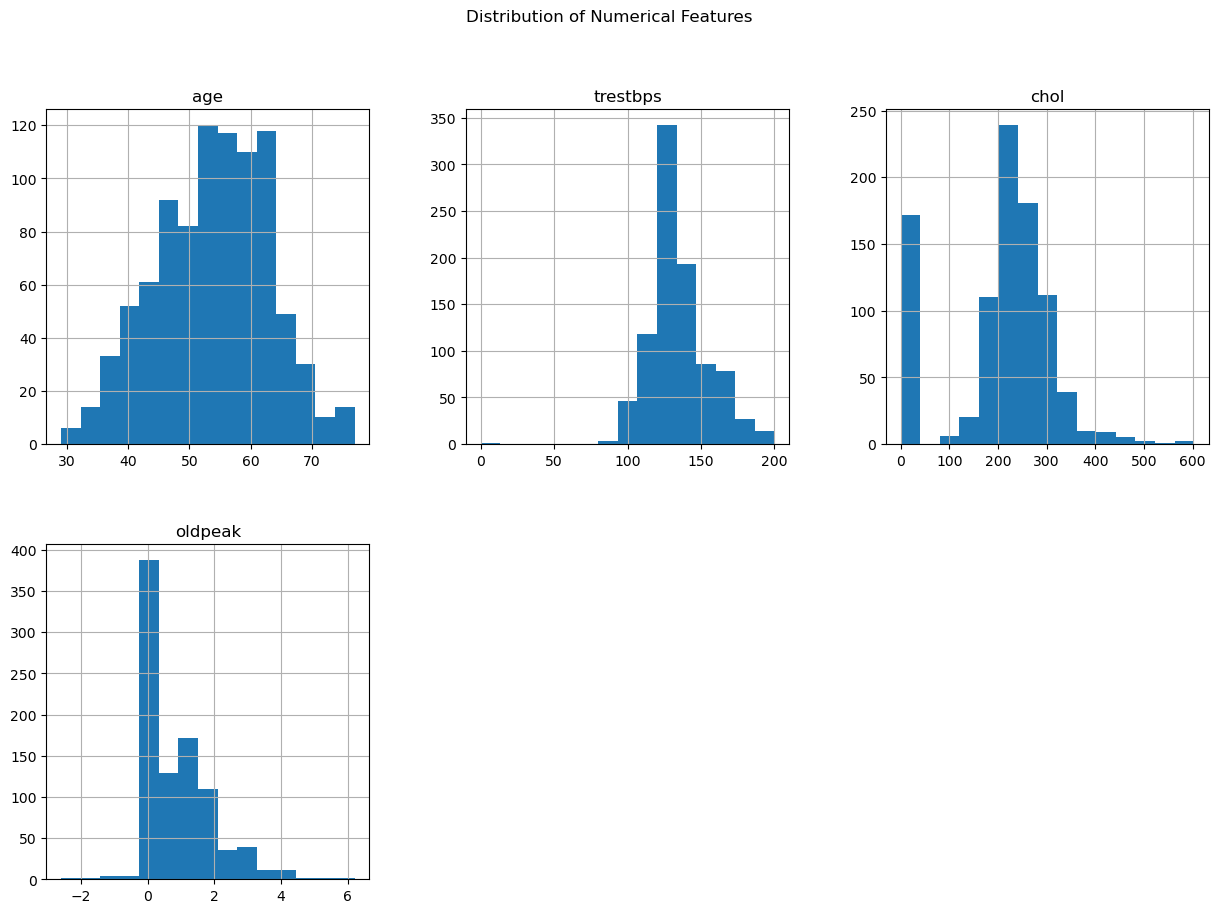

In [15]:
# Visualize the distribution of numerical features
numerical_features = ['age', 'trestbps', 'chol', 'oldpeak']
df[numerical_features].hist(bins=15, figsize=(15, 10), layout=(2, 3))
plt.suptitle('Distribution of Numerical Features')
plt.show()

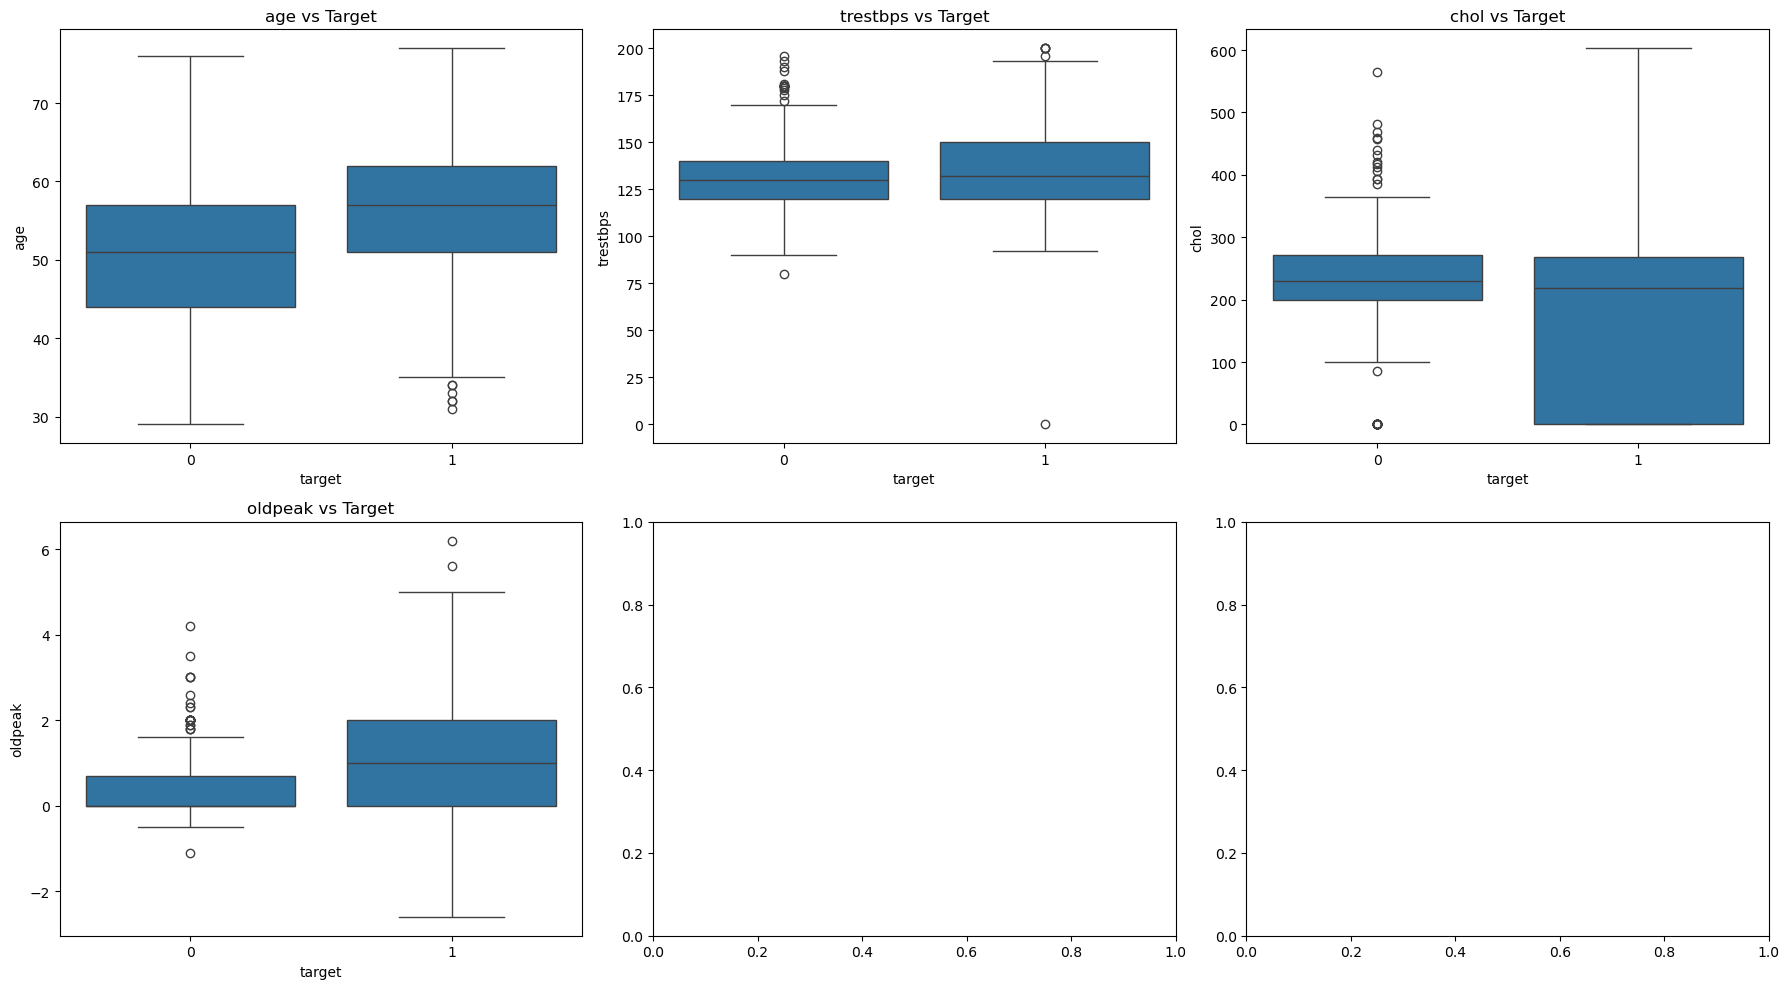

In [16]:
# Visualize relationships with the target variable using box plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
for i, col in enumerate(numerical_features):
    sns.boxplot(x='target', y=col, data=df, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'{col} vs Target')
plt.tight_layout()
plt.show()

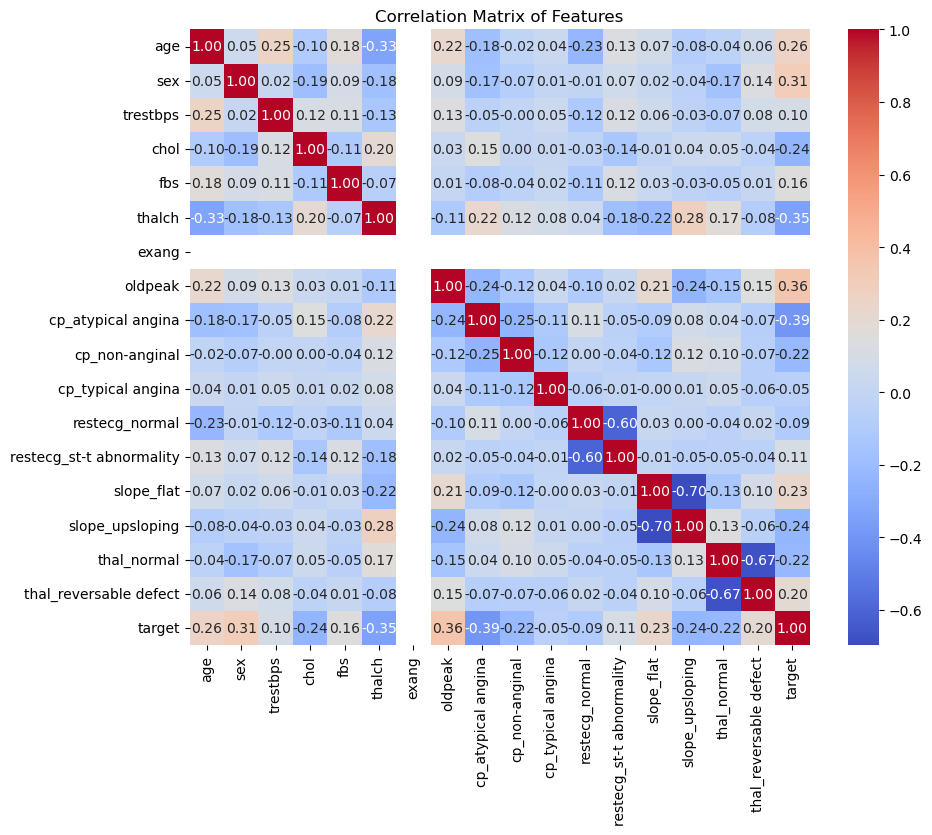

In [17]:
# Correlation matrix
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

## 3. Feature Engineering

In [18]:
# Define features (X) and target (y)
X = df.drop('target', axis=1)
y = df['target']

In [19]:
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (908, 17)
Target shape: (908,)


## 4. Decision Tree Classification

In [20]:
# Split the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 726
Testing set size: 182


In [22]:
# Implement and train a basic Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [23]:
# Make predictions on the test set
y_pred = dt_classifier.predict(X_test)
y_pred_proba = dt_classifier.predict_proba(X_test)[:, 1]

In [24]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [43]:
print("\n--- Basic Decision Tree Model Evaluation ---")
print(f"Accuracy:  {accuracy:}")
print(f"Precision: {precision:}")
print(f"Recall:    {recall:}")
print(f"F1-Score:  {f1:}")
print(f"ROC-AUC:   {roc_auc:}")


--- Basic Decision Tree Model Evaluation ---
Accuracy:  0.7142857142857143
Precision: 0.7659574468085106
Recall:    0.7058823529411765
F1-Score:  0.7346938775510204
ROC-AUC:   0.7154411764705882


## Visualization

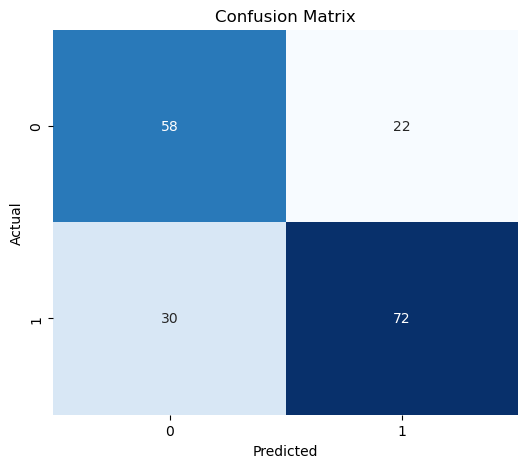

In [26]:
# Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

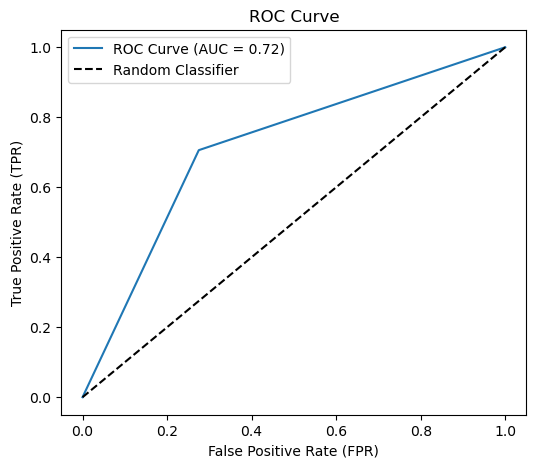

In [27]:
# Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()

## 5. Hyperparameter Tuning

In [28]:
# Define the parameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [29]:
# Create the GridSearchCV object
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='f1', n_jobs=-1)

In [30]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='f1')

In [31]:
# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation F1 score: ", grid_search.best_score_)

Best parameters found:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best cross-validation F1 score:  0.776003740612565


In [32]:
# Get the best model
best_dt_model = grid_search.best_estimator_

In [33]:
# Evaluate the best model on the test set
y_pred_best = best_dt_model.predict(X_test)
y_pred_proba_best = best_dt_model.predict_proba(X_test)[:, 1]

In [34]:
accuracy_tuned = accuracy_score(y_test, y_pred_best)
precision_tuned = precision_score(y_test, y_pred_best)
recall_tuned = recall_score(y_test, y_pred_best)
f1_tuned = f1_score(y_test, y_pred_best)
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_best)

In [44]:
print("\n--- Tuned Decision Tree Model Evaluation ---")
print(f"Accuracy:  {accuracy_tuned:}")
print(f"Precision: {precision_tuned:}")
print(f"Recall:    {recall_tuned:}")
print(f"F1-Score:  {f1_tuned:}")
print(f"ROC-AUC:   {roc_auc_tuned:}")


--- Tuned Decision Tree Model Evaluation ---
Accuracy:  0.7472527472527473
Precision: 0.7916666666666666
Recall:    0.7450980392156863
F1-Score:  0.7676767676767676
ROC-AUC:   0.7951593137254902


## 6. Model Evaluation and Analysis

In [57]:
# Compare performance
print("\n--- Performance Comparison ---")
print(f"{'Metric':}    | {'Basic Model':}         | {'Tuned Model':}")
print("-" * 45)
print(f"{'Accuracy':}  | {accuracy:} | {accuracy_tuned:}")
print(f"{'Precision':} | {precision:} | {precision_tuned:}")
print(f"{'Recall':}    | {recall:} | {recall_tuned:}")
print(f"{'F1-Score':}  | {f1:} | {f1_tuned:}")
print(f"{'ROC-AUC':}   | {roc_auc:} | {roc_auc_tuned:}")



--- Performance Comparison ---
Metric    | Basic Model         | Tuned Model
---------------------------------------------
Accuracy  | 0.7142857142857143 | 0.7472527472527473
Precision | 0.7659574468085106 | 0.7916666666666666
Recall    | 0.7058823529411765 | 0.7450980392156863
F1-Score  | 0.7346938775510204 | 0.7676767676767676
ROC-AUC   | 0.7154411764705882 | 0.7951593137254902


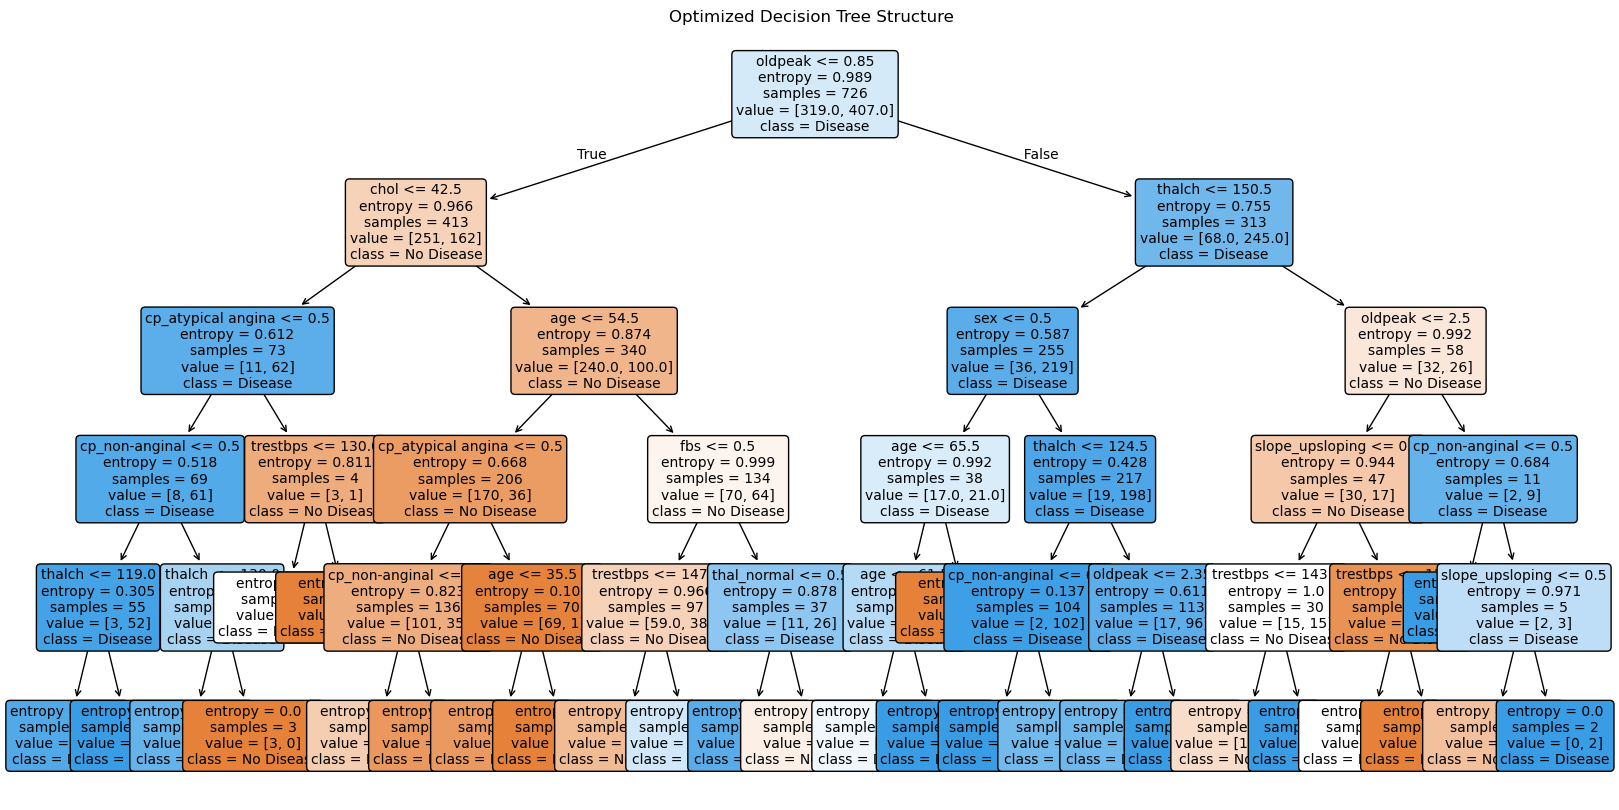

In [37]:
# Visualize the tuned decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_dt_model, 
          feature_names=X.columns,
          class_names=['No Disease', 'Disease'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Optimized Decision Tree Structure')
plt.show()

In [38]:
# Feature Importance
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': best_dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n--- Feature Importances ---")
print(feature_importances)


--- Feature Importances ---
                     feature  importance
7                    oldpeak    0.286386
3                       chol    0.166956
5                     thalch    0.138567
0                        age    0.116708
8         cp_atypical angina    0.069798
9             cp_non-anginal    0.064741
1                        sex    0.055795
2                   trestbps    0.042422
4                        fbs    0.022239
14           slope_upsloping    0.022126
15               thal_normal    0.014260
6                      exang    0.000000
10         cp_typical angina    0.000000
12  restecg_st-t abnormality    0.000000
11            restecg_normal    0.000000
13                slope_flat    0.000000
16    thal_reversable defect    0.000000


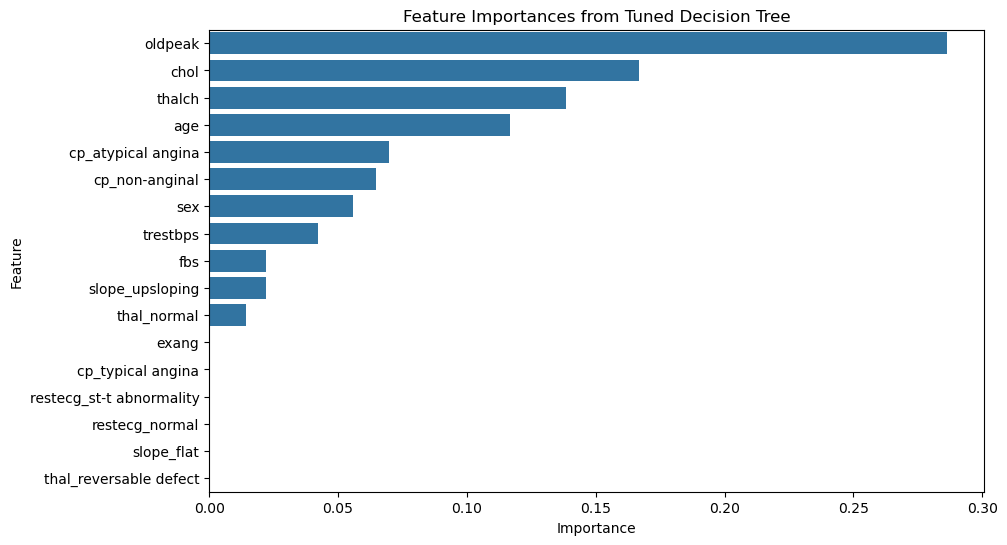

In [39]:
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importances from Tuned Decision Tree')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### **Interview Questions**

1.  **What are some common hyperparameters of decision tree models, and how do they affect the model's performance?**

      * **`max_depth`**: This parameter limits the maximum depth of the tree. A small `max_depth` can prevent the model from capturing complex relationships (underfitting), while a very large depth can lead to the model learning noise in the data (overfitting). It's crucial for controlling the model's complexity.
      * **`min_samples_split`**: The minimum number of samples required to split an internal node. A higher value prevents the tree from creating too many splits on small groups of data, which helps to reduce overfitting.
      * **`min_samples_leaf`**: The minimum number of samples required to be at a leaf node. Similar to `min_samples_split`, a higher value constrains the tree from becoming too complex and helps in generalizing better to unseen data.
      * **`criterion`**: This defines the function used to measure the quality of a split. The two common criteria are **Gini impurity** (`gini`) and **information gain** (`entropy`). Both are designed to find the best split point. `Gini` measures the probability of a randomly chosen element being incorrectly classified, while `Entropy` measures the randomness or unpredictability of the split. They usually yield similar results in practice.

2.  **What is the difference between Label Encoding and One-hot Encoding?**

      * **Label Encoding** : This technique assigns a unique integer to each category of a categorical feature. For example, `['red', 'green', 'blue']` might become `[0, 1, 2]`. This is useful when the categories have an ordinal relationship (e.g., `['small', 'medium', 'large']`). However, for nominal data (data without an inherent order), it can introduce a false sense of order or magnitude, which can mislead some machine learning models (like linear models). Decision Trees are less susceptible to this as they are rule-based and don't assume a linear relationship.
      * **One-hot Encoding** : This method creates a new binary column for each unique category in a categorical feature. For each row, the value in the new column is `1` if the row's original category matches that column's category, and `0` otherwise. For example, `['red', 'green', 'blue']` would become three columns: `red`, `green`, and `blue`. This prevents the model from assuming an incorrect ordinal relationship between categories. It is the preferred method for nominal categorical data, especially for linear models. The downside is that it can increase the dimensionality of the dataset, which can be an issue with a high number of unique categories.